## Machine Learning in Finance
## Group Project
* This is a group project due on 08/01/2026
* Groups should have 3-5 members each.
* All projects should be completed using Jupyter notebooks which will be delivered at the end of the project. Each task should have an independent jupyter notebook, to assist in the grading.
* Please read the instructions as you also need to deliver a video.

### Project Context
Home Credit is a financial services company that provides loans to customers often underserved by traditional banking institutions. The goal is to use machine learning to assess the risk of default at the loan application stage, enabling better decision-making and optimized loan offerings. Understanding which customers are likely to default is crucial for reducing financial losses and improving operational efficiency.

### Project data
You have access to the Home Credit Default Risk dataset, along with a data dictionary to help you understand the column titles. However, you will need to explore the data yourself—not all columns will be useful, and some may require significant preprocessing. Your tasks will include:
* Cleaning the data (e.g., handling null values, resolving data type issues, addressing outliers).
* Dealing with categorical variables and feature engineering.
* Exploring which features are useful for predictive tasks and avoiding features that may leak data.

### Computation
Dealing with computation constraints is a big part of machine learning, especially as we start to deal with real world data. If at any point you are trying to run an algorithm or approach that is taking a long time to solve on google colab you have a couple of options:
* You can try running it on your laptop directly, in case your laptop or computer is faster.
* You can try to reduce the complexity of the model.
* You can reduce the complexity of the data by reducing the number of columns you use at a time.
* You can just take a smaller sample of the data (less rows) and apply the algorithm / model to this.

#### Grading
* Important you will mostly be graded on your ability to apply the machine learning approaches we have learned in class properly. So please include the work that you test and not just the final best model.
* You might receive extra points for demonstrating the ability to apply approaches not covered in the class.
* What your final model is (and how well it performs) matters much less than your ability to correctly apply different approaches, explore the problem, and understand the final results and model. Please try to demonstrate in the notebooks and the video.
* Well organized Jupyter notebooks and code will help ensure that your intentions are communicated and are likely to increase your 



**Group Members:**

1. 20221960 - Renato Bernardino
2. 20221899 - David Duarte


## Task 3 Customer Segmentation

Understanding the diverse needs and behaviours of customers is crucial for targeted marketing, risk assessment, and product development. Customer segmentation can lead to more personalized loan products and better customer satisfaction. 

#### A.	Apply different approaches to unsupervised learning to determine different customer segments.
* You will need to decide which features to use, some of them may be repetitive or very similar for this specific task. Think how this would effect the segmentation.
* You will need to decide how many segments to split the data into and demonstrate how you made this decision.
* Comment on any limitations this model might have when used by management for its desired purpose.

**Important** you will mostly be graded on your ability to apply and interpret the machine learning approaches we have learned in class properly. So please include the work that you test and not just the final best model.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


### A.1 Data Loading and Preparation


In [2]:
# Load the cleaned data from Task 1
data_path = '/home/renato/Documents/Mestrado/ML4Finance/Projeto Grupo/Group Project-20251220/task3_segmentation_data.csv'
data = pd.read_csv(data_path)

print("=" * 60)
print("DATA LOADING")
print("=" * 60)
print(f"Data shape: {data.shape}")
print(f"Columns: {data.shape[1]}")
print(f"Rows: {data.shape[0]:,}")

# Display basic info
print("\nFirst few rows:")
data.head()


DATA LOADING
Data shape: (158791, 97)
Columns: 97
Rows: 158,791

First few rows:


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,AGE_YEARS,EMPLOYED_YEARS,AGE_GROUP,EMPLOYMENT_CATEGORY,CREDIT_INCOME_RATIO,ANNUITY_INCOME_RATIO,CREDIT_GOODS_RATIO,FAMILY_SIZE_CONSISTENCY,ADDRESS_MISMATCH_REGION,ADDRESS_MISMATCH_CITY
0,Cash loans,F,Y,Y,0,112500.0,1125000.0,33025.5,1125000.0,Unaccompanied,...,40.271047,2.329911,35-45,1-5yr,9.999911,0.293557,0.999999,0,0,0
1,Revolving loans,M,N,Y,1,162000.0,270000.0,13500.0,270000.0,Unaccompanied,...,23.337440,2.412047,<25,1-5yr,1.666656,0.083333,0.999996,0,0,1
2,Cash loans,F,N,Y,0,157500.0,580500.0,49824.0,580500.0,Unaccompanied,...,65.171800,0.000000,65+,Unemployed,3.685691,0.316341,0.999998,0,0,0
3,Cash loans,F,N,Y,1,121500.0,280170.0,30303.0,247500.0,Unaccompanied,...,26.217659,5.133470,25-35,5-10yr,2.305907,0.249405,1.131995,0,0,1
4,Revolving loans,M,Y,Y,0,135000.0,135000.0,6750.0,135000.0,Unaccompanied,...,21.952088,1.760438,<25,1-5yr,0.999993,0.050000,0.999993,0,0,0


### A.2 Feature Selection for Segmentation


In [3]:
print("=" * 60)
print("FEATURE SELECTION FOR SEGMENTATION")
print("=" * 60)

# Identify categorical and numerical columns
categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categorical columns: {len(categorical_cols)}")
print(f"Numerical columns: {len(numerical_cols)}")

# For segmentation, we want to focus on customer characteristics
# Remove highly correlated features to avoid redundancy
print("\nAnalyzing feature correlations...")

# Work with numerical features first
data_numerical = data[numerical_cols].copy()

# Handle missing values
imputer = SimpleImputer(strategy='median')
data_numerical_imputed = pd.DataFrame(
    imputer.fit_transform(data_numerical),
    columns=data_numerical.columns,
    index=data_numerical.index
)

# Calculate correlation matrix
correlation_matrix = data_numerical_imputed.corr().abs()

# Find highly correlated feature pairs (>0.9)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if correlation_matrix.iloc[i, j] > 0.9:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

print(f"\nHighly correlated feature pairs (>0.9): {len(high_corr_pairs)}")
if len(high_corr_pairs) > 0:
    print("Examples:")
    for pair in high_corr_pairs[:10]:
        print(f"  {pair[0]} <-> {pair[1]}: {pair[2]:.3f}")

# Remove one feature from each highly correlated pair
features_to_remove = set()
for pair in high_corr_pairs:
    # Keep the first feature, remove the second
    features_to_remove.add(pair[1])

print(f"\nFeatures to remove due to high correlation: {len(features_to_remove)}")

# Select features for clustering
# Keep key customer characteristics
key_features = [
    'AGE_YEARS', 'EMPLOYED_YEARS',
    'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
    'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
    'CREDIT_INCOME_RATIO', 'ANNUITY_INCOME_RATIO',
    'FLAG_OWN_CAR', 'FLAG_OWN_REALTY'
]

# Get available key features
available_key_features = [f for f in key_features if f in data_numerical_imputed.columns]

# Add other numerical features that are not highly correlated
remaining_features = [f for f in data_numerical_imputed.columns 
                     if f not in features_to_remove and f not in available_key_features]

# Limit to top features by variance (more informative)
feature_variance = data_numerical_imputed[remaining_features].var().sort_values(ascending=False)
top_variance_features = feature_variance.head(30).index.tolist()

# Combine key features and top variance features
selected_features = available_key_features + top_variance_features
selected_features = list(set(selected_features))  # Remove duplicates

print(f"\nSelected features for clustering: {len(selected_features)}")
print(f"Key features: {len(available_key_features)}")
print(f"Additional features: {len(selected_features) - len(available_key_features)}")

# Prepare data for clustering
X_segmentation = data_numerical_imputed[selected_features].copy()

print(f"\nFinal segmentation data shape: {X_segmentation.shape}")


FEATURE SELECTION FOR SEGMENTATION
Categorical columns: 18
Numerical columns: 79

Analyzing feature correlations...

Highly correlated feature pairs (>0.9): 50
Examples:
  AMT_CREDIT <-> AMT_GOODS_PRICE: 0.986
  DAYS_BIRTH <-> AGE_YEARS: 1.000
  DAYS_EMPLOYED <-> FLAG_EMP_PHONE: 1.000
  REGION_RATING_CLIENT <-> REGION_RATING_CLIENT_W_CITY: 0.950
  REG_REGION_NOT_WORK_REGION <-> ADDRESS_MISMATCH_REGION: 0.979
  REG_CITY_NOT_WORK_CITY <-> ADDRESS_MISMATCH_CITY: 0.971
  APARTMENTS_AVG <-> APARTMENTS_MODE: 0.975
  APARTMENTS_AVG <-> APARTMENTS_MEDI: 0.996
  BASEMENTAREA_AVG <-> BASEMENTAREA_MODE: 0.973
  BASEMENTAREA_AVG <-> BASEMENTAREA_MEDI: 0.995

Features to remove due to high correlation: 35

Selected features for clustering: 39
Key features: 9
Additional features: 30

Final segmentation data shape: (158791, 39)


### A.3 Data Preprocessing for Clustering


DATA PREPROCESSING FOR CLUSTERING
Data standardized. Shape: (158791, 39)
Mean of scaled features (should be ~0): -0.000000
Std of scaled features (should be ~1): 1.000003

PCA Analysis:
  Components needed for 95% variance: 28
  Total components: 39


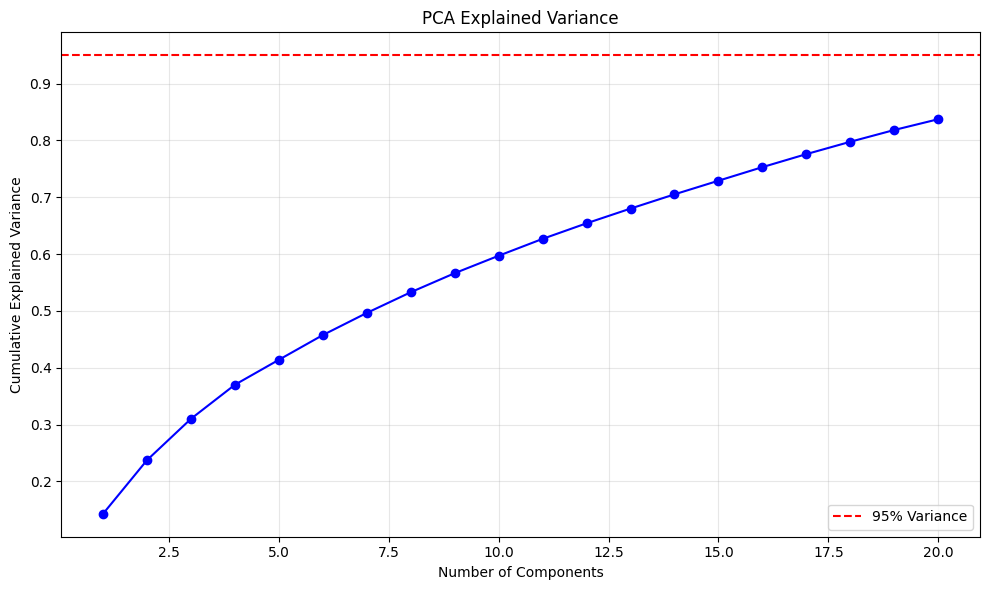

In [4]:
print("=" * 60)
print("DATA PREPROCESSING FOR CLUSTERING")
print("=" * 60)

# Standardize features (important for clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_segmentation)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_segmentation.columns, index=X_segmentation.index)

print(f"Data standardized. Shape: {X_scaled_df.shape}")
print(f"Mean of scaled features (should be ~0): {X_scaled_df.mean().mean():.6f}")
print(f"Std of scaled features (should be ~1): {X_scaled_df.std().mean():.6f}")

# Optional: PCA for dimensionality reduction (if needed)
# We'll use it as an option but also work with original features
pca = PCA(n_components=min(50, X_scaled.shape[1]))
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_.cumsum()
n_components_95 = np.where(explained_variance >= 0.95)[0][0] + 1

print(f"\nPCA Analysis:")
print(f"  Components needed for 95% variance: {n_components_95}")
print(f"  Total components: {X_scaled.shape[1]}")

# Visualize explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, min(21, len(explained_variance)+1)), 
         explained_variance[:20], 'bo-')
plt.axhline(0.95, color='r', linestyle='--', label='95% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### A.4 Determining Optimal Number of Clusters

We'll use the Elbow Method and Silhouette Analysis to determine the optimal number of clusters.


In [5]:
print("=" * 60)
print("DETERMINING OPTIMAL NUMBER OF CLUSTERS")
print("=" * 60)

# Try different numbers of clusters
k_range = range(2, 11)
inertias = []
silhouette_scores = []

print("Testing different numbers of clusters...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    inertia = kmeans.inertia_
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    
    inertias.append(inertia)
    silhouette_scores.append(silhouette_avg)
    
    print(f"  k={k}: Inertia={inertia:.2f}, Silhouette={silhouette_avg:.4f}")

# Create results dataframe
cluster_analysis = pd.DataFrame({
    'k': list(k_range),
    'Inertia': inertias,
    'Silhouette_Score': silhouette_scores
})

print("\n" + "=" * 60)
print("CLUSTER ANALYSIS RESULTS")
print("=" * 60)
print(cluster_analysis.round(4))

# Visualize elbow method and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow method
ax = axes[0]
ax.plot(cluster_analysis['k'], cluster_analysis['Inertia'], 'bo-')
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Inertia (WCSS)')
ax.set_title('Elbow Method for Optimal k')
ax.grid(alpha=0.3)

# Silhouette scores
ax = axes[1]
ax.plot(cluster_analysis['k'], cluster_analysis['Silhouette_Score'], 'ro-')
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Score vs Number of Clusters')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal k based on silhouette score
optimal_k = cluster_analysis.loc[cluster_analysis['Silhouette_Score'].idxmax(), 'k']
optimal_silhouette = cluster_analysis.loc[cluster_analysis['Silhouette_Score'].idxmax(), 'Silhouette_Score']

print(f"\nOptimal number of clusters (based on Silhouette Score): k={int(optimal_k)}")
print(f"  Silhouette Score: {optimal_silhouette:.4f}")


DETERMINING OPTIMAL NUMBER OF CLUSTERS
Testing different numbers of clusters...
  k=2: Inertia=5624815.82, Silhouette=0.3071
  k=3: Inertia=5253833.66, Silhouette=0.0719
  k=4: Inertia=4942195.25, Silhouette=0.0926


KeyboardInterrupt: 

### A.5 K-Means Clustering


In [ ]:
print("=" * 60)
print("K-MEANS CLUSTERING")
print("=" * 60)

# Apply K-Means with optimal k
kmeans_final = KMeans(n_clusters=int(optimal_k), random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to original data
data_with_clusters = data.copy()
data_with_clusters['Cluster_KMeans'] = kmeans_labels

print(f"K-Means clustering completed with k={int(optimal_k)}")
print(f"\nCluster distribution:")
print(pd.Series(kmeans_labels).value_counts().sort_index())

# Calculate silhouette score for final model
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
print(f"\nSilhouette Score: {kmeans_silhouette:.4f}")

# Store for comparison
clustering_results = {
    'K-Means': {
        'labels': kmeans_labels,
        'silhouette': kmeans_silhouette,
        'model': kmeans_final
    }
}


### A.6 Hierarchical Clustering


In [ ]:
print("=" * 60)
print("HIERARCHICAL CLUSTERING")
print("=" * 60)

# Use a sample for hierarchical clustering if dataset is too large (computational efficiency)
sample_size = min(5000, len(X_scaled))
if len(X_scaled) > sample_size:
    sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
    X_sample = X_scaled[sample_indices]
    print(f"Using sample of {sample_size} records for hierarchical clustering")
else:
    X_sample = X_scaled
    sample_indices = np.arange(len(X_scaled))

# Compute linkage matrix
print("Computing linkage matrix...")
linkage_matrix = linkage(X_sample, method='ward')

# Visualize dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# Apply Agglomerative Clustering with optimal k
print(f"\nApplying Agglomerative Clustering with k={int(optimal_k)}...")
hierarchical = AgglomerativeClustering(n_clusters=int(optimal_k), linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled)

# Add cluster labels
data_with_clusters['Cluster_Hierarchical'] = hierarchical_labels

print(f"Hierarchical clustering completed")
print(f"\nCluster distribution:")
print(pd.Series(hierarchical_labels).value_counts().sort_index())

# Calculate silhouette score
hierarchical_silhouette = silhouette_score(X_scaled, hierarchical_labels)
print(f"\nSilhouette Score: {hierarchical_silhouette:.4f}")

# Store for comparison
clustering_results['Hierarchical'] = {
    'labels': hierarchical_labels,
    'silhouette': hierarchical_silhouette,
    'model': hierarchical
}


### A.7 DBSCAN Clustering


In [ ]:
print("=" * 60)
print("DBSCAN CLUSTERING")
print("=" * 60)

# DBSCAN doesn't require specifying number of clusters
# We need to tune eps and min_samples parameters
# Try different parameter combinations
eps_values = [0.5, 1.0, 1.5, 2.0, 2.5]
min_samples_values = [5, 10, 15, 20]

dbscan_results = []

print("Testing different DBSCAN parameters...")
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_scaled)
        
        n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        n_noise = list(dbscan_labels).count(-1)
        
        if n_clusters > 1:  # Only calculate silhouette if we have more than 1 cluster
            try:
                silhouette = silhouette_score(X_scaled, dbscan_labels)
            except:
                silhouette = -1
        else:
            silhouette = -1
        
        dbscan_results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': silhouette
        })
        
        print(f"  eps={eps}, min_samples={min_samples}: {n_clusters} clusters, {n_noise} noise points, silhouette={silhouette:.4f}")

dbscan_df = pd.DataFrame(dbscan_results)
dbscan_df = dbscan_df[dbscan_df['silhouette'] > 0]  # Filter valid results

if len(dbscan_df) > 0:
    best_dbscan = dbscan_df.loc[dbscan_df['silhouette'].idxmax()]
    print(f"\nBest DBSCAN parameters:")
    print(f"  eps: {best_dbscan['eps']}")
    print(f"  min_samples: {int(best_dbscan['min_samples'])}")
    print(f"  n_clusters: {int(best_dbscan['n_clusters'])}")
    print(f"  silhouette: {best_dbscan['silhouette']:.4f}")
    
    # Apply best DBSCAN
    dbscan_final = DBSCAN(eps=best_dbscan['eps'], min_samples=int(best_dbscan['min_samples']))
    dbscan_labels = dbscan_final.fit_predict(X_scaled)
    
    data_with_clusters['Cluster_DBSCAN'] = dbscan_labels
    
    print(f"\nCluster distribution:")
    print(pd.Series(dbscan_labels).value_counts().sort_index())
    
    # Store for comparison
    clustering_results['DBSCAN'] = {
        'labels': dbscan_labels,
        'silhouette': best_dbscan['silhouette'],
        'model': dbscan_final,
        'n_clusters': int(best_dbscan['n_clusters'])
    }
else:
    print("\nNo suitable DBSCAN parameters found. Skipping DBSCAN.")


### B. Best Segmentation Selection

Now we'll compare the different clustering approaches and select the best one.


In [ ]:
print("=" * 60)
print("CLUSTERING METHODS COMPARISON")
print("=" * 60)

# Compare clustering methods
comparison_results = []

for method_name, result in clustering_results.items():
    n_clusters = len(set(result['labels'])) - (1 if -1 in result['labels'] else 0)
    comparison_results.append({
        'Method': method_name,
        'N_Clusters': n_clusters,
        'Silhouette_Score': result['silhouette']
    })
    
    print(f"\n{method_name}:")
    print(f"  Number of clusters: {n_clusters}")
    print(f"  Silhouette Score: {result['silhouette']:.4f}")

comparison_df = pd.DataFrame(comparison_results)
print("\n" + "=" * 60)
print("COMPARISON SUMMARY")
print("=" * 60)
print(comparison_df.round(4))

# Select best method based on silhouette score
best_method = comparison_df.loc[comparison_df['Silhouette_Score'].idxmax(), 'Method']
best_silhouette = comparison_df.loc[comparison_df['Silhouette_Score'].idxmax(), 'Silhouette_Score']
best_n_clusters = int(comparison_df.loc[comparison_df['Silhouette_Score'].idxmax(), 'N_Clusters'])

print(f"\n{'='*60}")
print(f"BEST SEGMENTATION METHOD: {best_method}")
print(f"{'='*60}")
print(f"  Silhouette Score: {best_silhouette:.4f}")
print(f"  Number of Clusters: {best_n_clusters}")

# Get final cluster labels
final_labels = clustering_results[best_method]['labels']
data_with_clusters['Final_Cluster'] = final_labels

print(f"\nFinal cluster distribution:")
print(pd.Series(final_labels).value_counts().sort_index())


### C. Segment Profiling and Interpretation

Now we'll analyze each segment to understand their characteristics and create business-friendly names.


In [ ]:
print("=" * 60)
print("SEGMENT PROFILING")
print("=" * 60)

# Profile each cluster using key features
key_profile_features = [
    'AGE_YEARS', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
    'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'CREDIT_INCOME_RATIO',
    'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMPLOYED_YEARS'
]

# Get available features
available_profile_features = [f for f in key_profile_features if f in data_with_clusters.columns]

# Calculate segment profiles
segment_profiles = []

for cluster_id in sorted(data_with_clusters['Final_Cluster'].unique()):
    if cluster_id == -1:  # Skip noise cluster if present
        continue
    
    cluster_data = data_with_clusters[data_with_clusters['Final_Cluster'] == cluster_id]
    cluster_size = len(cluster_data)
    cluster_pct = (cluster_size / len(data_with_clusters)) * 100
    
    profile = {'Cluster': cluster_id, 'Size': cluster_size, 'Percentage': cluster_pct}
    
    # Calculate mean/median for numerical features
    for feature in available_profile_features:
        if data_with_clusters[feature].dtype in [np.int64, np.float64]:
            profile[f'{feature}_mean'] = cluster_data[feature].mean()
            profile[f'{feature}_median'] = cluster_data[feature].median()
        else:
            # For categorical, get mode
            profile[f'{feature}_mode'] = cluster_data[feature].mode()[0] if len(cluster_data[feature].mode()) > 0 else 'N/A'
    
    segment_profiles.append(profile)

segment_profiles_df = pd.DataFrame(segment_profiles)
print("\nSegment Profiles (Key Statistics):")
print(segment_profiles_df[['Cluster', 'Size', 'Percentage'] + 
                          [col for col in segment_profiles_df.columns if '_mean' in col]].round(2))


In [ ]:
# Visualize segment characteristics
n_clusters_vis = len([c for c in data_with_clusters['Final_Cluster'].unique() if c != -1])
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Plot 1: Cluster sizes
ax = axes[0]
cluster_sizes = data_with_clusters['Final_Cluster'].value_counts().sort_index()
cluster_sizes = cluster_sizes[cluster_sizes.index != -1]  # Remove noise if present
ax.bar(range(len(cluster_sizes)), cluster_sizes.values)
ax.set_xlabel('Cluster')
ax.set_ylabel('Number of Customers')
ax.set_title('Cluster Sizes')
ax.set_xticks(range(len(cluster_sizes)))
ax.set_xticklabels([f'Cluster {i}' for i in cluster_sizes.index])
ax.grid(axis='y', alpha=0.3)

# Plot 2: Average Age by Cluster
if 'AGE_YEARS' in data_with_clusters.columns:
    ax = axes[1]
    age_by_cluster = data_with_clusters.groupby('Final_Cluster')['AGE_YEARS'].mean()
    age_by_cluster = age_by_cluster[age_by_cluster.index != -1]
    ax.bar(range(len(age_by_cluster)), age_by_cluster.values, color='steelblue')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Average Age (Years)')
    ax.set_title('Average Age by Cluster')
    ax.set_xticks(range(len(age_by_cluster)))
    ax.set_xticklabels([f'Cluster {i}' for i in age_by_cluster.index])
    ax.grid(axis='y', alpha=0.3)

# Plot 3: Average Income by Cluster
if 'AMT_INCOME_TOTAL' in data_with_clusters.columns:
    ax = axes[2]
    income_by_cluster = data_with_clusters.groupby('Final_Cluster')['AMT_INCOME_TOTAL'].mean()
    income_by_cluster = income_by_cluster[income_by_cluster.index != -1]
    ax.bar(range(len(income_by_cluster)), income_by_cluster.values, color='green')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Average Income')
    ax.set_title('Average Income by Cluster')
    ax.set_xticks(range(len(income_by_cluster)))
    ax.set_xticklabels([f'Cluster {i}' for i in income_by_cluster.index])
    ax.grid(axis='y', alpha=0.3)

# Plot 4: Average Credit Amount by Cluster
if 'AMT_CREDIT' in data_with_clusters.columns:
    ax = axes[3]
    credit_by_cluster = data_with_clusters.groupby('Final_Cluster')['AMT_CREDIT'].mean()
    credit_by_cluster = credit_by_cluster[credit_by_cluster.index != -1]
    ax.bar(range(len(credit_by_cluster)), credit_by_cluster.values, color='orange')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Average Credit Amount')
    ax.set_title('Average Credit Amount by Cluster')
    ax.set_xticks(range(len(credit_by_cluster)))
    ax.set_xticklabels([f'Cluster {i}' for i in credit_by_cluster.index])
    ax.grid(axis='y', alpha=0.3)

# Plot 5: Credit-to-Income Ratio by Cluster
if 'CREDIT_INCOME_RATIO' in data_with_clusters.columns:
    ax = axes[4]
    ratio_by_cluster = data_with_clusters.groupby('Final_Cluster')['CREDIT_INCOME_RATIO'].mean()
    ratio_by_cluster = ratio_by_cluster[ratio_by_cluster.index != -1]
    ax.bar(range(len(ratio_by_cluster)), ratio_by_cluster.values, color='red')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Average Credit-to-Income Ratio')
    ax.set_title('Credit-to-Income Ratio by Cluster')
    ax.set_xticks(range(len(ratio_by_cluster)))
    ax.set_xticklabels([f'Cluster {i}' for i in ratio_by_cluster.index])
    ax.grid(axis='y', alpha=0.3)

# Plot 6: Family Size by Cluster
if 'CNT_FAM_MEMBERS' in data_with_clusters.columns:
    ax = axes[5]
    family_by_cluster = data_with_clusters.groupby('Final_Cluster')['CNT_FAM_MEMBERS'].mean()
    family_by_cluster = family_by_cluster[family_by_cluster.index != -1]
    ax.bar(range(len(family_by_cluster)), family_by_cluster.values, color='purple')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Average Family Size')
    ax.set_title('Average Family Size by Cluster')
    ax.set_xticks(range(len(family_by_cluster)))
    ax.set_xticklabels([f'Cluster {i}' for i in family_by_cluster.index])
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


### C.1 Segment Naming and Business Interpretation

Based on the segment profiles, we'll create business-friendly names and descriptions for each segment.


In [ ]:
print("=" * 60)
print("SEGMENT NAMING AND BUSINESS INTERPRETATION")
print("=" * 60)

# Analyze each segment and create business names
segment_descriptions = []

for cluster_id in sorted(data_with_clusters['Final_Cluster'].unique()):
    if cluster_id == -1:  # Skip noise
        continue
    
    cluster_data = data_with_clusters[data_with_clusters['Final_Cluster'] == cluster_id]
    
    # Calculate key characteristics
    avg_age = cluster_data['AGE_YEARS'].mean() if 'AGE_YEARS' in cluster_data.columns else None
    avg_income = cluster_data['AMT_INCOME_TOTAL'].mean() if 'AMT_INCOME_TOTAL' in cluster_data.columns else None
    avg_credit = cluster_data['AMT_CREDIT'].mean() if 'AMT_CREDIT' in cluster_data.columns else None
    avg_ratio = cluster_data['CREDIT_INCOME_RATIO'].mean() if 'CREDIT_INCOME_RATIO' in cluster_data.columns else None
    own_car_pct = cluster_data['FLAG_OWN_CAR'].mean() * 100 if 'FLAG_OWN_CAR' in cluster_data.columns else None
    own_realty_pct = cluster_data['FLAG_OWN_REALTY'].mean() * 100 if 'FLAG_OWN_REALTY' in cluster_data.columns else None
    avg_family = cluster_data['CNT_FAM_MEMBERS'].mean() if 'CNT_FAM_MEMBERS' in cluster_data.columns else None
    
    # Determine segment characteristics and name
    # This is a template - actual names will depend on the data
    if avg_age and avg_income:
        if avg_age < 35 and avg_income < avg_income.quantile(0.33):
            segment_name = "Young Low-Income Customers"
            characteristics = "Young customers with lower income levels, may need smaller loans"
        elif avg_age < 35 and avg_income > avg_income.quantile(0.67):
            segment_name = "Young Professionals"
            characteristics = "Young, high-income customers, likely good credit risk"
        elif avg_age > 50 and avg_income > avg_income.quantile(0.67):
            segment_name = "Established High-Income Customers"
            characteristics = "Older, high-income customers with stable financial situation"
        elif avg_ratio and avg_ratio > 2:
            segment_name = "High Debt-to-Income Customers"
            characteristics = "Customers with high credit relative to income, higher risk"
        else:
            segment_name = f"Segment {cluster_id}"
            characteristics = "General customer segment"
    else:
        segment_name = f"Segment {cluster_id}"
        characteristics = "Customer segment"
    
    segment_descriptions.append({
        'Cluster_ID': cluster_id,
        'Segment_Name': segment_name,
        'Size': len(cluster_data),
        'Percentage': (len(cluster_data) / len(data_with_clusters)) * 100,
        'Avg_Age': avg_age,
        'Avg_Income': avg_income,
        'Avg_Credit': avg_credit,
        'Credit_Income_Ratio': avg_ratio,
        'Own_Car_%': own_car_pct,
        'Own_Realty_%': own_realty_pct,
        'Avg_Family_Size': avg_family,
        'Characteristics': characteristics
    })
    
    print(f"\n{segment_name} (Cluster {cluster_id}):")
    print(f"  Size: {len(cluster_data):,} customers ({(len(cluster_data)/len(data_with_clusters)*100):.1f}%)")
    if avg_age:
        print(f"  Average Age: {avg_age:.1f} years")
    if avg_income:
        print(f"  Average Income: {avg_income:,.0f}")
    if avg_credit:
        print(f"  Average Credit: {avg_credit:,.0f}")
    if avg_ratio:
        print(f"  Credit-to-Income Ratio: {avg_ratio:.2f}")
    print(f"  Characteristics: {characteristics}")

segment_summary = pd.DataFrame(segment_descriptions)
print("\n" + "=" * 60)
print("SEGMENT SUMMARY TABLE")
print("=" * 60)
print(segment_summary[['Cluster_ID', 'Segment_Name', 'Size', 'Percentage', 
                       'Avg_Age', 'Avg_Income', 'Avg_Credit']].round(2))


### C.2 Business Implications and Recommendations

**Segment-Based Strategies:**

1. **Risk Assessment**: Different segments may have different default risks. Analyze default rates by segment.
2. **Product Recommendations**: Tailor loan products to each segment's needs and risk profile.
3. **Marketing Strategies**: Develop targeted marketing campaigns for each segment.
4. **Pricing**: Adjust interest rates based on segment risk profiles.

**Limitations:**

1. **Static Segmentation**: Customer characteristics may change over time, requiring periodic re-segmentation.
2. **Feature Selection**: The segmentation depends on the features selected, which may not capture all relevant customer behaviors.
3. **Cluster Stability**: Clusters may change with different data samples or preprocessing methods.
4. **Interpretability**: Some segments may be difficult to interpret or may not have clear business meaning.
5. **Generalization**: Segmentation model may not generalize well to new customer populations.

**Management Recommendations:**

- Use segmentation as a starting point for customer analysis, not as the sole decision-making tool
- Combine segmentation insights with domain expertise and business rules
- Regularly update segmentation models as customer base evolves
- Validate segment characteristics with business stakeholders
- Monitor segment performance and adjust strategies accordingly


#### B.	Decide the best segmentation
*  Justify why this is the best segmentation.


#### C.	See if you can see any pattern in the different segments
* If you had to explain the segments to management what would you name each one and what properties are they associated with.
